# Step 0: Set it up

In [50]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# customize the style
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 12

# load the data
filepath = './dataset/PJME_hourly.csv'
df = pd.read_csv(filepath)

print("Now, you're ready for step one")

Now, you're ready for step one


# Step 1: Explore the data
---
To better understand the data, I need to create a graph to see the change in PJM Energy over time.

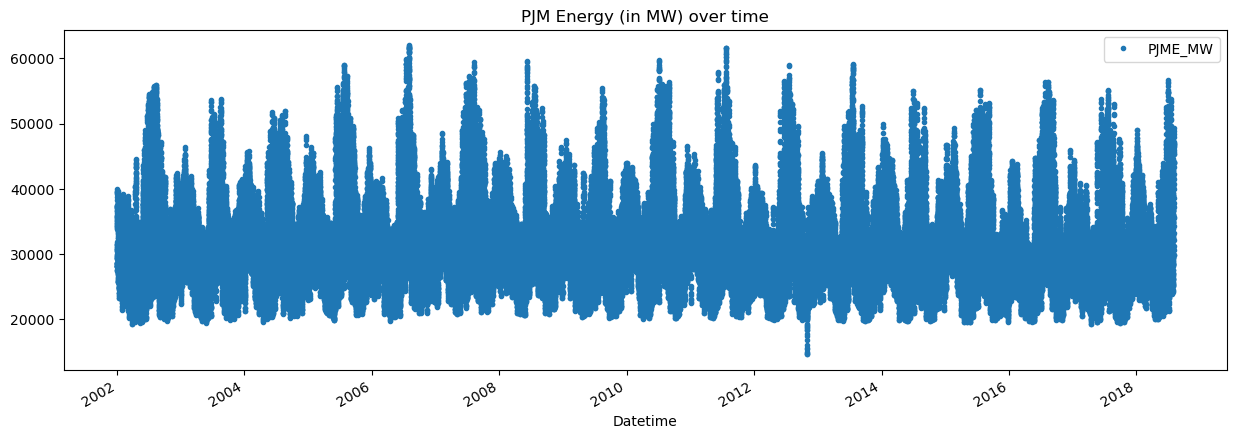

In [51]:
# turn data to datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

# create the plot
df.plot(style='.',
        figsize=(15, 5),
        title='PJM Energy (in MW) over time')
plt.show()

# Step 2: Split the data
---
Everything prior to January 2015 will be our training data and keep our test data as the following dates.


In [52]:
# train / test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']


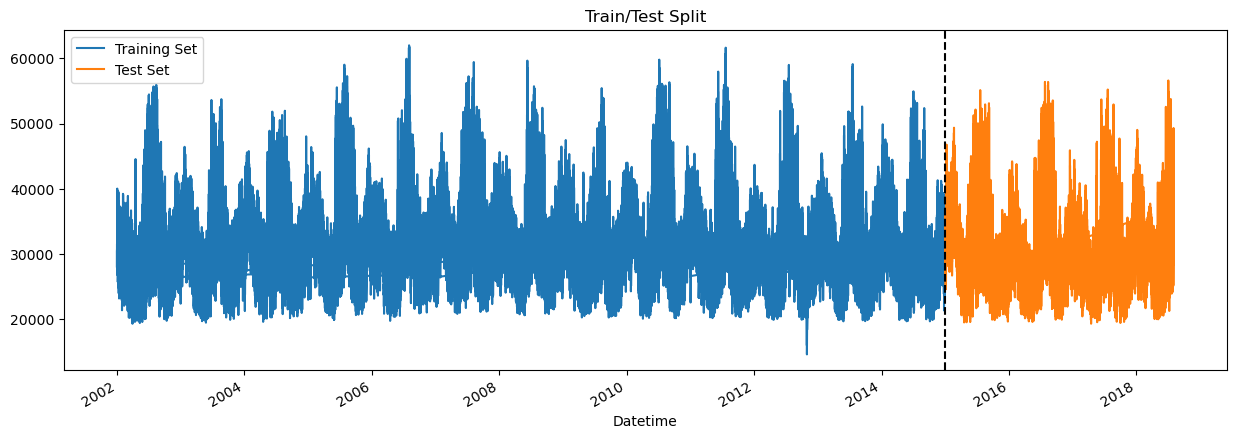

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Step 3: Feature Engineering
---
We're going to create some time features using the `Datetime` index. After that, we'll explore the distributions of `Hourly` and `Monthly` megawatt usage.

In [54]:
# feature creation
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Added cyclical features for hour and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    return df

df = create_features(df)
print(df.columns)


Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos'],
      dtype='object')


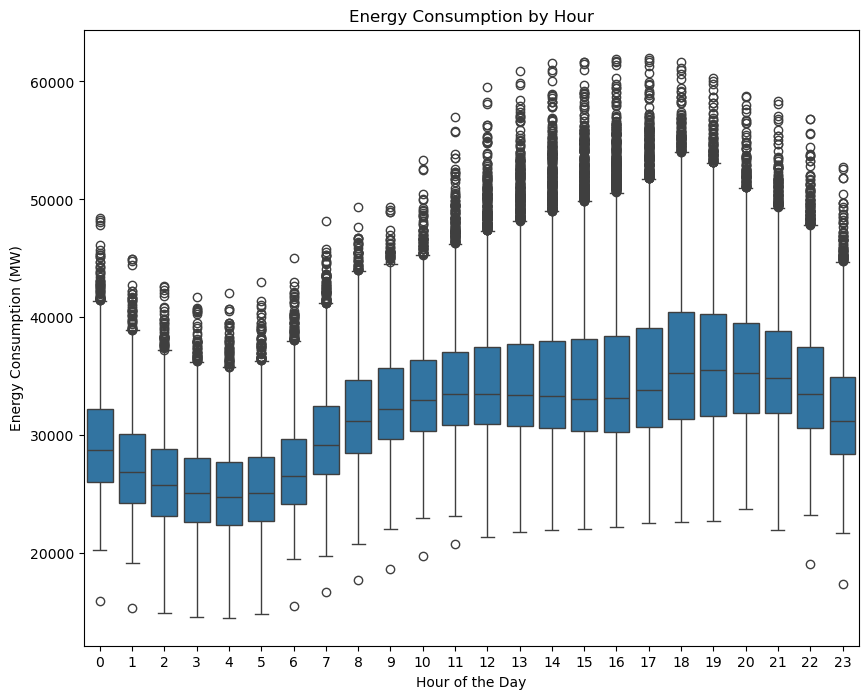

In [55]:
# visualize the hourly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Energy Consumption by Hour')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

/var/folders/pf/0svdqj5x4sdd8r21hmfkfd9m0000gn/T/ipykernel_36285/3833788313.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


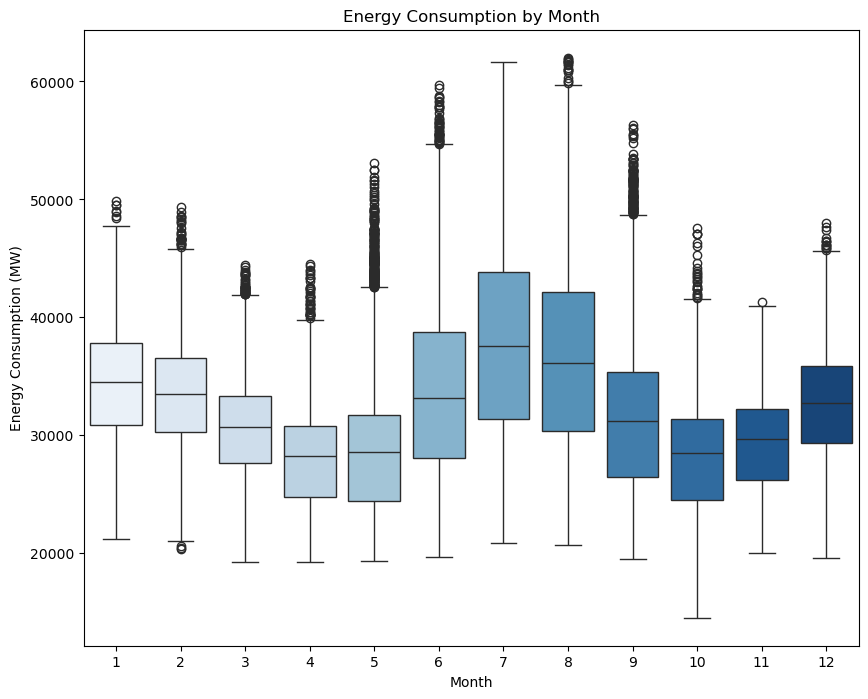

In [56]:
# Convert month to string# viaualize the monthly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('Energy Consumption by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

# Step 4: Modelling
---
`XGBoost` is good and reliable model for regression and time series analysis as well. Also, for the metrics, we'll use `mean squared error`.

### 4.1 Prepare the data

In [57]:
# preprocessing
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### 4.2 Build the model

In [58]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# build the regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,  # Increased the number of estimators
                       early_stopping_rounds=100,  # More early stopping rounds
                       objective='reg:squarederror',  # Changed to squarederror
                       max_depth=5,  # Increased max_depth
                       learning_rate=0.05)  # Adjusted learning rate

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:31303.40550	validation_1-rmse:30355.94856
[100]	validation_0-rmse:2868.46044	validation_1-rmse:3736.24150
[176]	validation_0-rmse:2636.69955	validation_1-rmse:3845.00714


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 4.3 Features importance
We need to see how much these features were used in each of the trees built by `XGBoost` model.

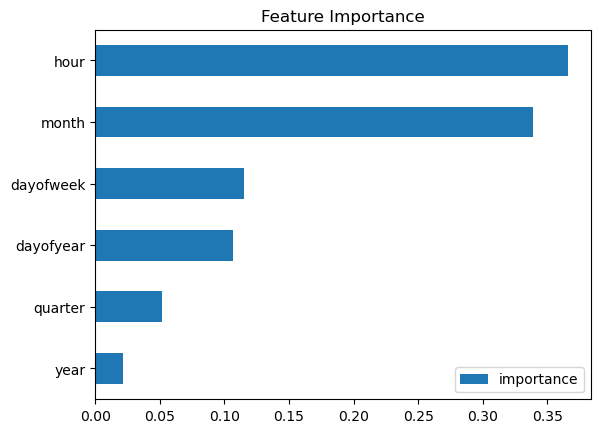

In [59]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Step 5: Forecasting on test data
compare the prediction with the actual values.

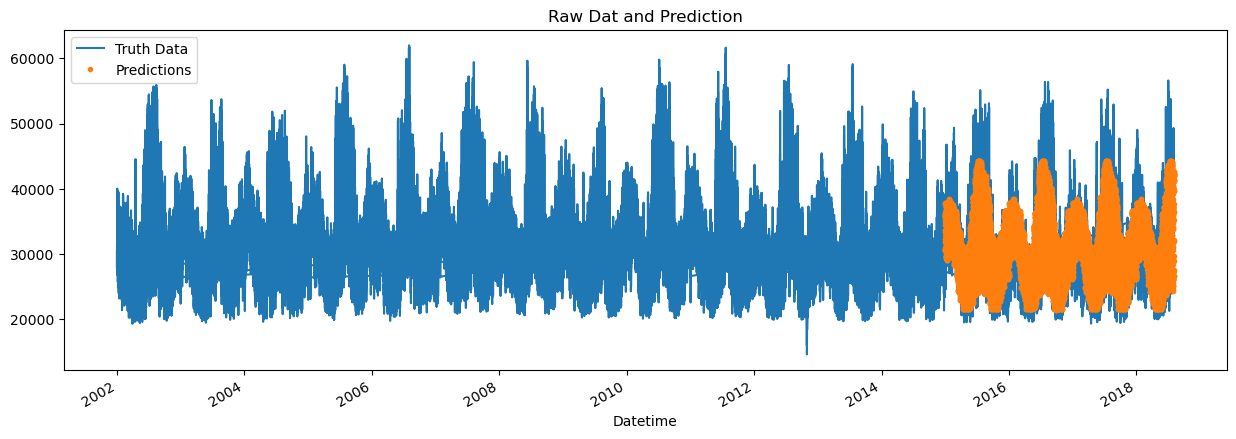

In [60]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Evaluation - RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
mae = mean_absolute_error(test['PJME_MW'], test['prediction'])
mape = mean_absolute_percentage_error(test['PJME_MW'], test['prediction'])

print(f'RMSE Score on Test set: {rmse:0.2f}')
print(f'MAE Score on Test set: {mae:0.2f}')
print(f'MAPE Score on Test set: {mape:0.2f}')

RMSE Score on Test set: 3681.31
MAE Score on Test set: 2764.84
MAPE Score on Test set: 0.09


In [62]:
# R2 Score
from sklearn.metrics import r2_score

r2 = r2_score(test['PJME_MW'], test['prediction'])
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.6742189453908711
